# Financial News and Stock Market Prediction

## Task 1

### Importing the Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import datetime
import warnings
import sys
import os
from textblob import TextBlob
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../scripts')))
from data_utils import  load_data,data_quality_check

#### Load the dataset

In [4]:
# Load the dataset
data_path = "../data/raw_analyst_ratings.csv"
df = load_data(data_path)

Data loaded successfully.


### Inspect the Data
#### Check the structure of the data (columns, data types, missing values).

In [3]:
missing_values, duplicate_rows = data_quality_check(df)
# Check the first few rows
df.head()


Missing values in each column:
 Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64
Number of duplicate rows: 0
Data types:
 Unnamed: 0     int64
headline      object
url           object
publisher     object
date          object
stock         object
dtype: object


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [ ]:

# Get summary information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB
None


## Descriptive Statistics

### Analyze the length of headlines

In [76]:
# Calculate headline lengths
df['headline_length'] = df['headline'].apply(len)

# Descriptive statistics for headline lengths
print(df['headline_length'].describe())


count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


In [ ]:
df.head()

,Unnamed: 0,headline,url,publisher,date,stock,headline_length
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,39
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,42
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,29
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,44
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,87


### Publisher Frequency Analysis
Count the number of articles per publisher

In [ ]:
# Number of articles per publisher
publisher_counts = df['publisher'].value_counts()
print(publisher_counts)


publisher
Paul Quintaro                      228373
Lisa Levin                         186979
Benzinga Newsdesk                  150484
Charles Gross                       96732
Monica Gerson                       82380
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: count, Length: 1034, dtype: int64


### Publication Date Trends
Convert the date column to datetime and analyze publication trends over time

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='ISO8601')

# Articles published per day
daily_articles = df.groupby(df['date'].dt.date).size()
print('Number of Articles per Day\n',daily_articles)


Number of Articles per Day
 date
2009-02-14      1
2009-04-27      2
2009-04-29      1
2009-05-22      1
2009-05-27      6
             ... 
2020-06-07     25
2020-06-08    765
2020-06-09    804
2020-06-10    806
2020-06-11    544
Length: 3955, dtype: int64


In [ ]:
# Check the datatype of the date column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype                    
---  ------           --------------    -----                    
 0   Unnamed: 0       1407328 non-null  int64                    
 1   headline         1407328 non-null  object                   
 2   url              1407328 non-null  object                   
 3   publisher        1407328 non-null  object                   
 4   date             1407328 non-null  datetime64[ns, UTC-04:00]
 5   stock            1407328 non-null  object                   
 6   headline_length  1407328 non-null  int64                    
dtypes: datetime64[ns, UTC-04:00](1), int64(2), object(4)
memory usage: 75.2+ MB


## Text Analysis

### Sentiment Analysis
Perform sentiment analysis on the headlines using TextBlob

In [77]:
# from textblob import TextBlob

# Function to classify sentiment polarity as positive, negative, or neutral
def classify_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis on headlines
df['polarity'] = df['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment'] = df['polarity'].apply(classify_sentiment)

# Display sentiment distribution
sentiment_distribution = df['sentiment'].value_counts()
print("Sentiment Distribution:\n", sentiment_distribution)




Sentiment Distribution:
 sentiment
neutral     934928
positive    341161
negative    131239
Name: count, dtype: int64


In [ ]:
df.head()

,Unnamed: 0,headline,url,publisher,date,stock,headline_length,polarity,sentiment
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,39,0.0,neutral
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,42,0.0,neutral
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,29,0.0,neutral
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,44,0.0,neutral
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,87,0.0,neutral


### Visualize Sentiment Distribution

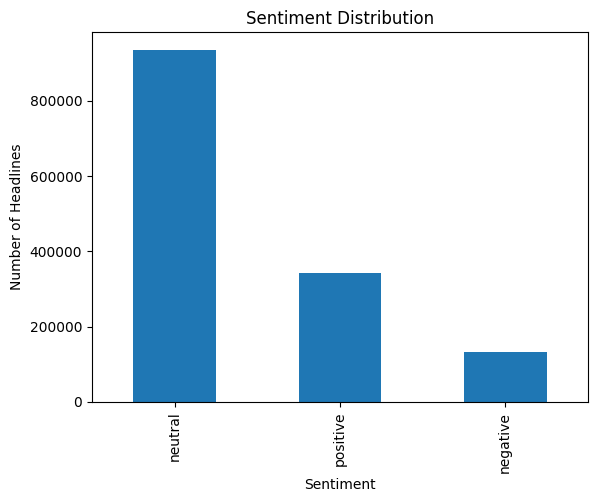

In [ ]:
import matplotlib.pyplot as plt

sentiment_distribution.plot(kind='bar', title='Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Headlines')
plt.show()


### Perform Topic Modeling


In [ ]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocess the headlines
def preprocess_text(text):
    # Tokenize and remove stopwords
    words = [word for word in text.lower().split() if word not in stop_words]
    return words

df['processed_headline'] = df['headline'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zelalem.wubet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df.head()

,Unnamed: 0,headline,url,publisher,date,stock,headline_length,polarity,sentiment,processed_headline
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,39,0.0,neutral,"[stocks, hit, 52-week, highs, friday]"
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,42,0.0,neutral,"[stocks, hit, 52-week, highs, wednesday]"
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,29,0.0,neutral,"[71, biggest, movers, friday]"
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,44,0.0,neutral,"[46, stocks, moving, friday's, mid-day, session]"
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,87,0.0,neutral,"[b, securities, maintains, neutral, agilent, t..."


In [ ]:
from gensim import corpora
# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(df['processed_headline'])

# Convert dictionary to a bag of words corpus
corpus = [dictionary.doc2bow(text) for text in df['processed_headline']]


In [ ]:
from gensim.models.ldamodel import LdaModel

# Set the number of topics
num_topics = 5

# Train the LDA model
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.067*"vs" + 0.055*"eps" + 0.045*"sales" + 0.040*"reports" + 0.023*"est"')
(1, '0.041*"stocks" + 0.021*"top" + 0.018*"etf" + 0.018*"retail" + 0.016*"benzinga\'s"')
(2, '0.047*"price" + 0.035*"pt" + 0.026*"raises" + 0.025*"maintains" + 0.025*"target"')
(3, '0.017*"says" + 0.012*"announces" + 0.009*"new" + 0.008*"reports" + 0.007*"western"')
(4, '0.031*"shares" + 0.018*"energy" + 0.014*"etfs" + 0.014*"update:" + 0.013*"pro"')


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)


## Time Series Analysis

### Analyze Publication Frequency Over Time

In [ ]:
# Ensure that the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

### Aggregate Data by Day

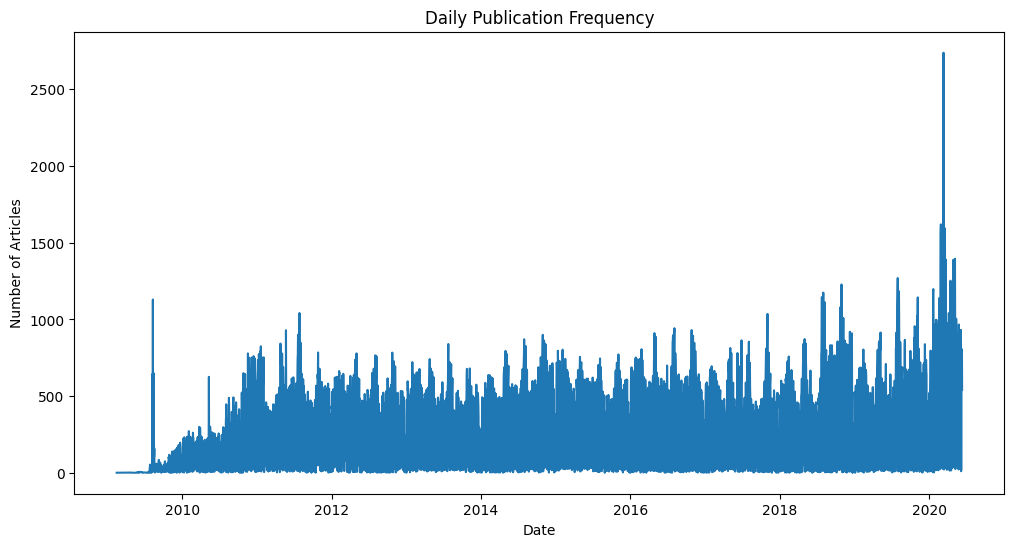

In [ ]:
# Group by the date (ignoring time) and count the number of articles per day
daily_publications = df.groupby(df['date'].dt.date).size()

# Plot the daily publication frequency
plt.figure(figsize=(12, 6))
daily_publications.plot(kind='line', title='Daily Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()


### Identify Spikes and Patterns
##### Manual Inspection: 
Look at the plot to identify any spikes in the number of articles published. These spikes might correspond to significant market events.
#### Annotate Events: 
If you know of specific market events, you can annotate the plot to show these events.

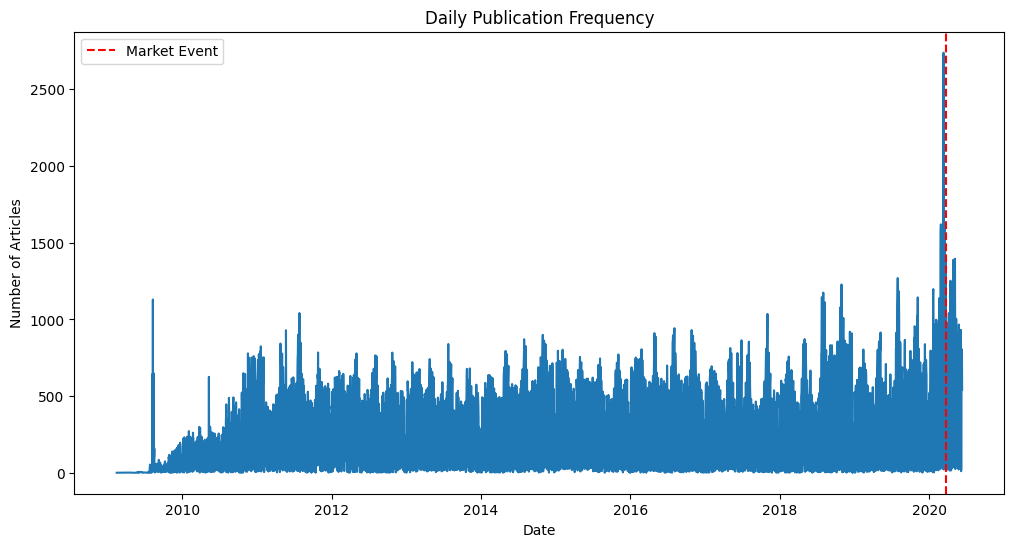

In [ ]:
# Example of annotating a spike (replace 'YYYY-MM-DD' with an actual date)
spike_date = '2020-03-24'
plt.figure(figsize=(12, 6))
daily_publications.plot(kind='line', title='Daily Publication Frequency')
plt.axvline(pd.to_datetime(spike_date), color='red', linestyle='--', label='Market Event')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend()
plt.show()


### Analyze Publishing Times
This analysis helps determine if there's a specific time of day when most articles are published, which could inform trading strategies or automated trading systems.

In [ ]:
# Extract the hour from the datetime
df['hour'] = df['date'].dt.hour
publish_counts = df['hour'].value_counts()

# Display the top publishers
print("published Hour:\n", publish_counts.head(20))
# df.head()

published Hour:
 hour
0     1351408
10       7669
9        5965
12       5732
11       5701
8        5527
7        5033
16       3939
17       2800
13       2710
6        2476
14       2075
5        1829
15       1612
4        1469
18        704
19        227
20        131
3          93
21         82
Name: count, dtype: int64


### Aggregate Data by Hour

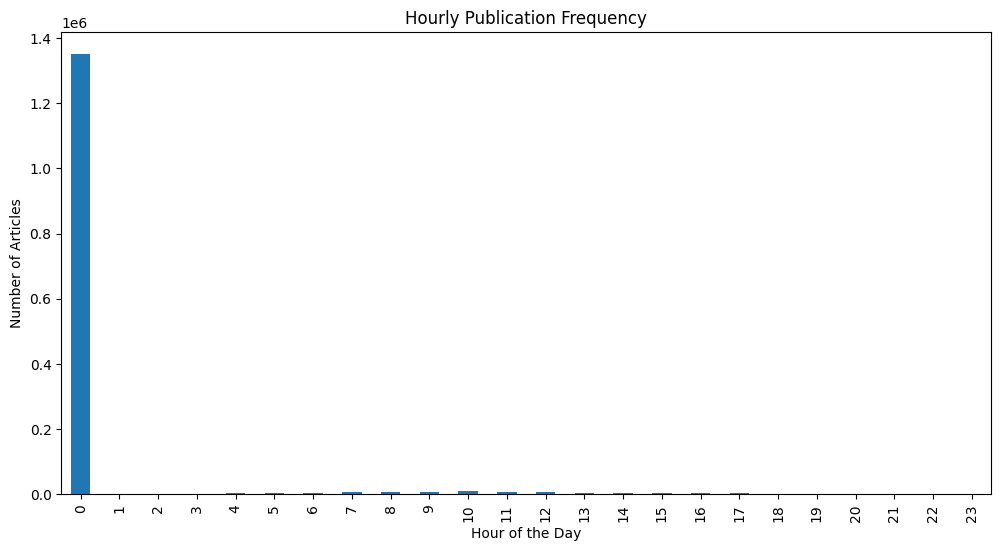

In [ ]:
# Group by the hour and count the number of articles published in each hour
hourly_publications = df.groupby('hour').size()

# Plot the hourly publication frequency
plt.figure(figsize=(12, 6))
hourly_publications.plot(kind='bar', title='Hourly Publication Frequency')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Articles')
plt.xticks(range(0, 24))  # Ensure x-axis covers all hours
plt.show()


## Publisher Analysis

### Analyze Publisher Contribution

#### Number of Articles per Publisher

In [ ]:
# Count the number of articles contributed by each publisher
publisher_counts = df['publisher'].value_counts()

# Display the top publishers
print("Top Publishers:\n", publisher_counts.head(10))


Top Publishers:
 publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


#### Visualize Publisher Contribution

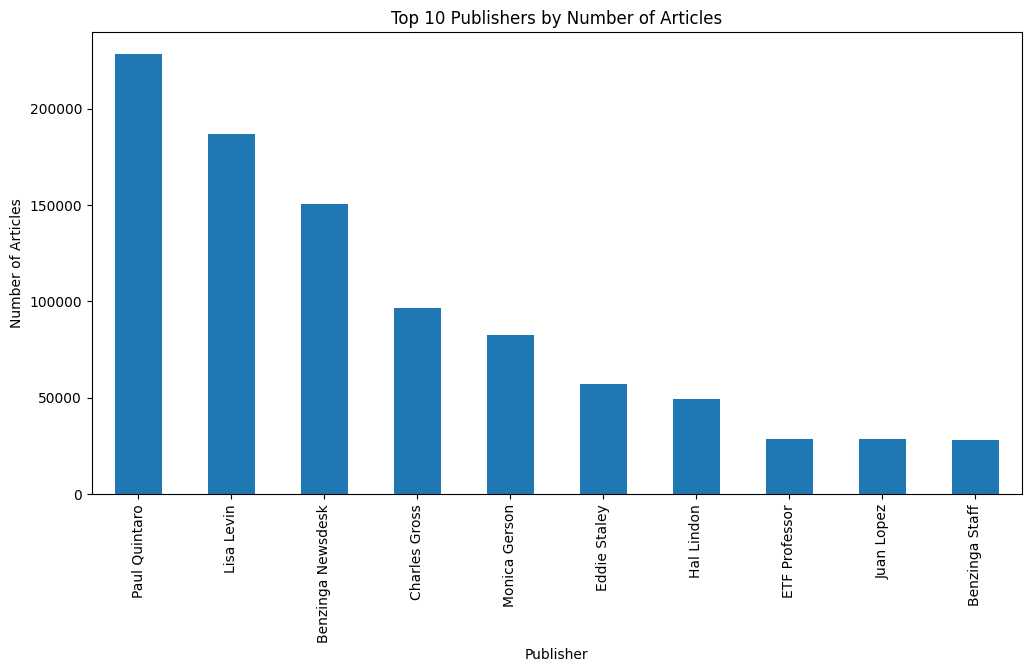

In [ ]:
# Plot the top 10 publishers
plt.figure(figsize=(12, 6))
publisher_counts.head(10).plot(kind='bar', title='Top 10 Publishers by Number of Articles')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.show()


#### Analyze Differences in the Type of News Reported

In [ ]:
# Perform sentiment analysis on headlines (assuming 'sentiment' column already exists)
publisher_sentiment = df.groupby('publisher')['sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Display sentiment distribution for top 10 publishers
top_publishers = publisher_counts.head(10).index
print("Sentiment Distribution for Top 10 Publishers:\n", publisher_sentiment.loc[top_publishers])


Sentiment Distribution for Top 10 Publishers:
 sentiment          negative   neutral  positive
publisher                                      
Paul Quintaro      0.099824  0.741616  0.158561
Lisa Levin         0.081779  0.687452  0.230769
Benzinga Newsdesk  0.145889  0.467166  0.386945
Charles Gross      0.082434  0.689058  0.228508
Monica Gerson      0.050777  0.541891  0.407332
Eddie Staley       0.077060  0.771684  0.151256
Hal Lindon         0.097947  0.724203  0.177850
ETF Professor      0.064481  0.731651  0.203868
Juan Lopez         0.020852  0.920705  0.058443
Benzinga Staff     0.066408  0.726755  0.206836


#### Visualize Sentiment Distribution

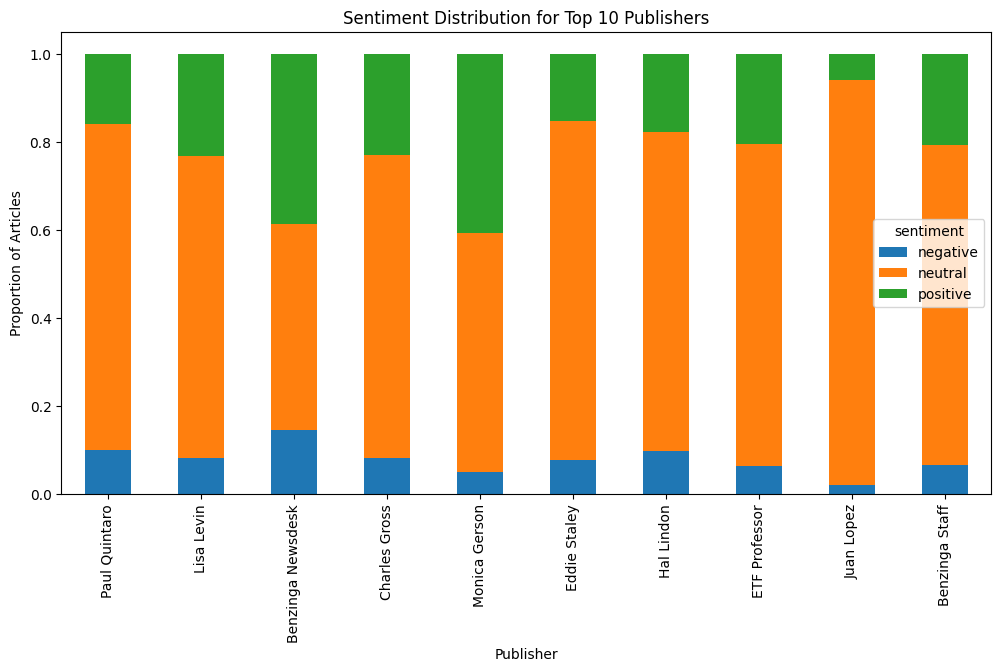

In [ ]:
# Plot sentiment distribution for a specific publisher
publisher_sentiment.loc[top_publishers].plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Distribution for Top 10 Publishers')
plt.xlabel('Publisher')
plt.ylabel('Proportion of Articles')
plt.show()


### Analyze Unique Domains if Publishers are Email Addresses

#### Extract Domains from Email Addresses

In [ ]:
# Extract the domain from the email addresses in the publisher column
df['domain'] = df['publisher'].apply(lambda x: x.split('@')[-1] if '@' in x else x)

# Display the first few domains
print("Sample Domains:\n", df['domain'].head())


Sample Domains:
 0    Benzinga Insights
1    Benzinga Insights
2           Lisa Levin
3           Lisa Levin
4           Vick Meyer
Name: domain, dtype: object


#### Count the Number of Articles per Domain

In [ ]:
# Count the number of articles contributed by each domain
domain_counts = df['domain'].value_counts()

# Display the top domains
print("Top Domains:\n", domain_counts.head(10))


Top Domains:
 domain
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


#### Visualize Domain Contribution

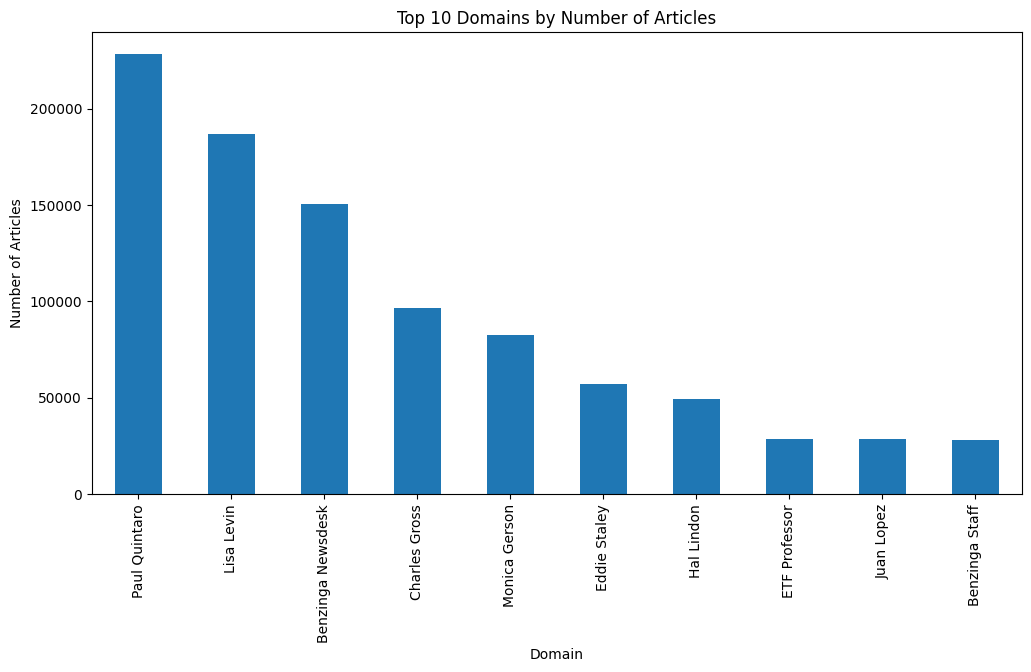

In [ ]:
# Plot the top 10 domains
plt.figure(figsize=(12, 6))
domain_counts.head(10).plot(kind='bar', title='Top 10 Domains by Number of Articles')
plt.xlabel('Domain')
plt.ylabel('Number of Articles')
plt.show()


#### Analyze Differences in the Type of News Reported by Domain

In [ ]:
# Perform sentiment analysis on headlines grouped by domain (assuming 'sentiment' column already exists)
domain_sentiment = df.groupby('domain')['sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Display sentiment distribution for top 10 domains
top_domains = domain_counts.head(10).index
print("Sentiment Distribution for Top 10 Domains:\n", domain_sentiment.loc[top_domains])


Sentiment Distribution for Top 10 Domains:
 sentiment          negative   neutral  positive
domain                                         
Paul Quintaro      0.099824  0.741616  0.158561
Lisa Levin         0.081779  0.687452  0.230769
Benzinga Newsdesk  0.145889  0.467166  0.386945
Charles Gross      0.082434  0.689058  0.228508
Monica Gerson      0.050777  0.541891  0.407332
Eddie Staley       0.077060  0.771684  0.151256
Hal Lindon         0.097947  0.724203  0.177850
ETF Professor      0.064481  0.731651  0.203868
Juan Lopez         0.020852  0.920705  0.058443
Benzinga Staff     0.066408  0.726755  0.206836


#### Visualize Sentiment Distribution by Domain

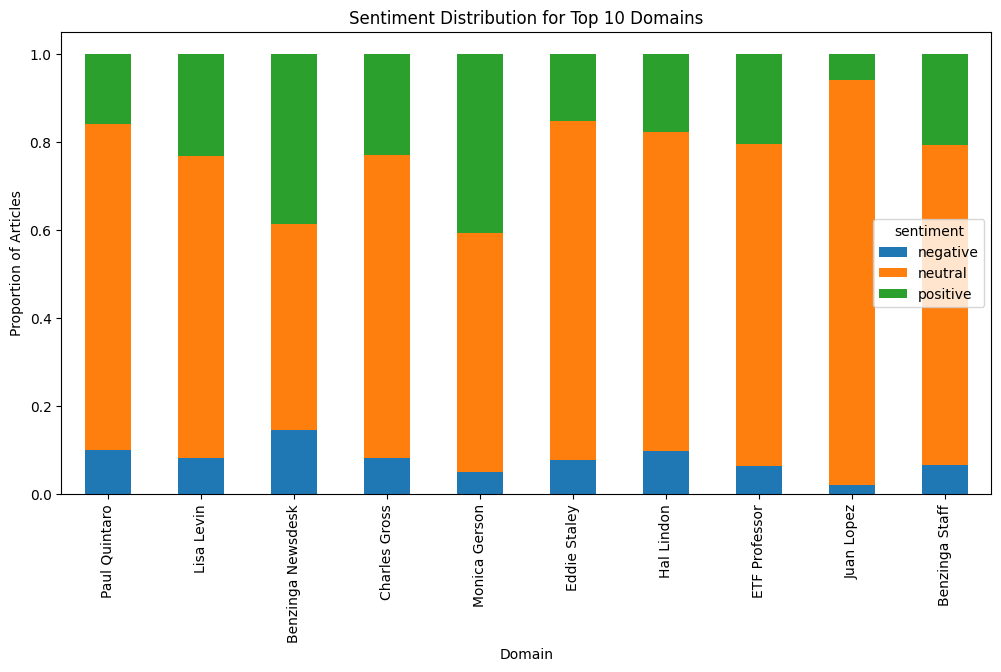

In [ ]:
# Plot sentiment distribution for a specific domain
domain_sentiment.loc[top_domains].plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Distribution for Top 10 Domains')
plt.xlabel('Domain')
plt.ylabel('Proportion of Articles')
plt.show()


In [ ]:
df.head()

,Unnamed: 0,headline,url,publisher,date,stock,headline_length,polarity,sentiment,processed_headline,hour,domain
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,39,0.0,neutral,"[stocks, hit, 52-week, highs, friday]",10,Benzinga Insights
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,42,0.0,neutral,"[stocks, hit, 52-week, highs, wednesday]",10,Benzinga Insights
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,29,0.0,neutral,"[71, biggest, movers, friday]",4,Lisa Levin
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,44,0.0,neutral,"[46, stocks, moving, friday's, mid-day, session]",12,Lisa Levin
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,87,0.0,neutral,"[b, securities, maintains, neutral, agilent, t...",11,Vick Meyer


## Task 2

### Quantitative analysis using pynance and TaLib

#### Import Libraries

In [73]:
import talib
import pandas as pd
import pynance as pn
import importlib
import data_utils
importlib.reload(data_utils)


<module 'data_utils' from 'c:\\Users\\zelalem.wubet\\projects\\personal\\ten-academy\\Financial-News-and-Stock-Price-Prediction\\scripts\\data_utils.py'>

### Apply Analysis Indicators with TA-Lib

#### Calculate Moving Averages (SMA and EMA)

In [26]:
# Calculate 20-day Simple Moving Average (SMA)
df['SMA_20'] = talib.SMA(df['Close'], timeperiod=20)

# Calculate 50-day Simple Moving Average (SMA)
df['SMA_50'] = talib.SMA(df['Close'], timeperiod=50)

# Calculate 20-day Exponential Moving Average (EMA)
df['EMA_20'] = talib.EMA(df['Close'], timeperiod=20)

#### Calculate Relative Strength Index (RSI)

In [27]:
# Calculate 14-day RSI
df['RSI_14'] = talib.RSI(df['Close'], timeperiod=14)

#### Calculate Moving Average Convergence Divergence (MACD)

In [28]:
# Calculate MACD, MACD Signal, and MACD Histogram
df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = talib.MACD(
    df['Close'], fastperiod=12, slowperiod=26, signalperiod=9
)


### Calculate financial metrics using PyNance

In [31]:
# Calculate financial metrics using PyNance
df['Daily_Returns'] = pn.data.Returns(df['Close']).daily()
df['Volatility'] = pn.data.Volatility(df['Close']).rolling(20)

Processing AAPL_historical_data.csv...
Data loaded successfully.
Missing values in each column:
 Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
Number of duplicate rows: 0
Data types:
 Date             object
Open            float64
High            float64
Low             float64
Close           float64
Adj Close       float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object


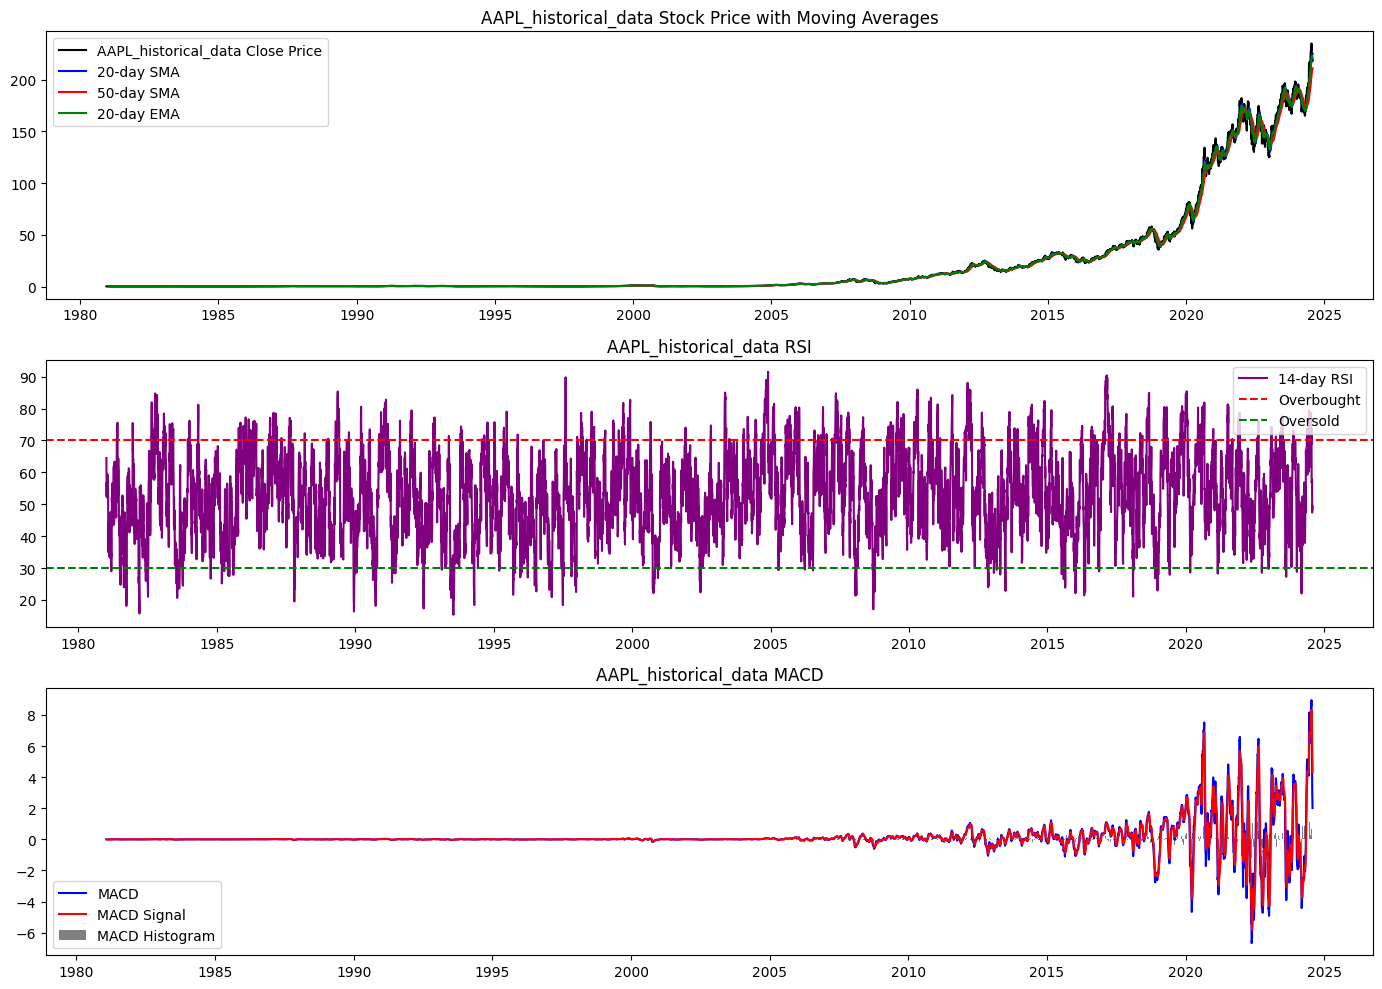

Saved processed data to ../data/yfinance_data\processed_AAPL_historical_data.csv.

Processing AMZN_historical_data.csv...
Data loaded successfully.
Missing values in each column:
 Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
Number of duplicate rows: 0
Data types:
 Date             object
Open            float64
High            float64
Low             float64
Close           float64
Adj Close       float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object


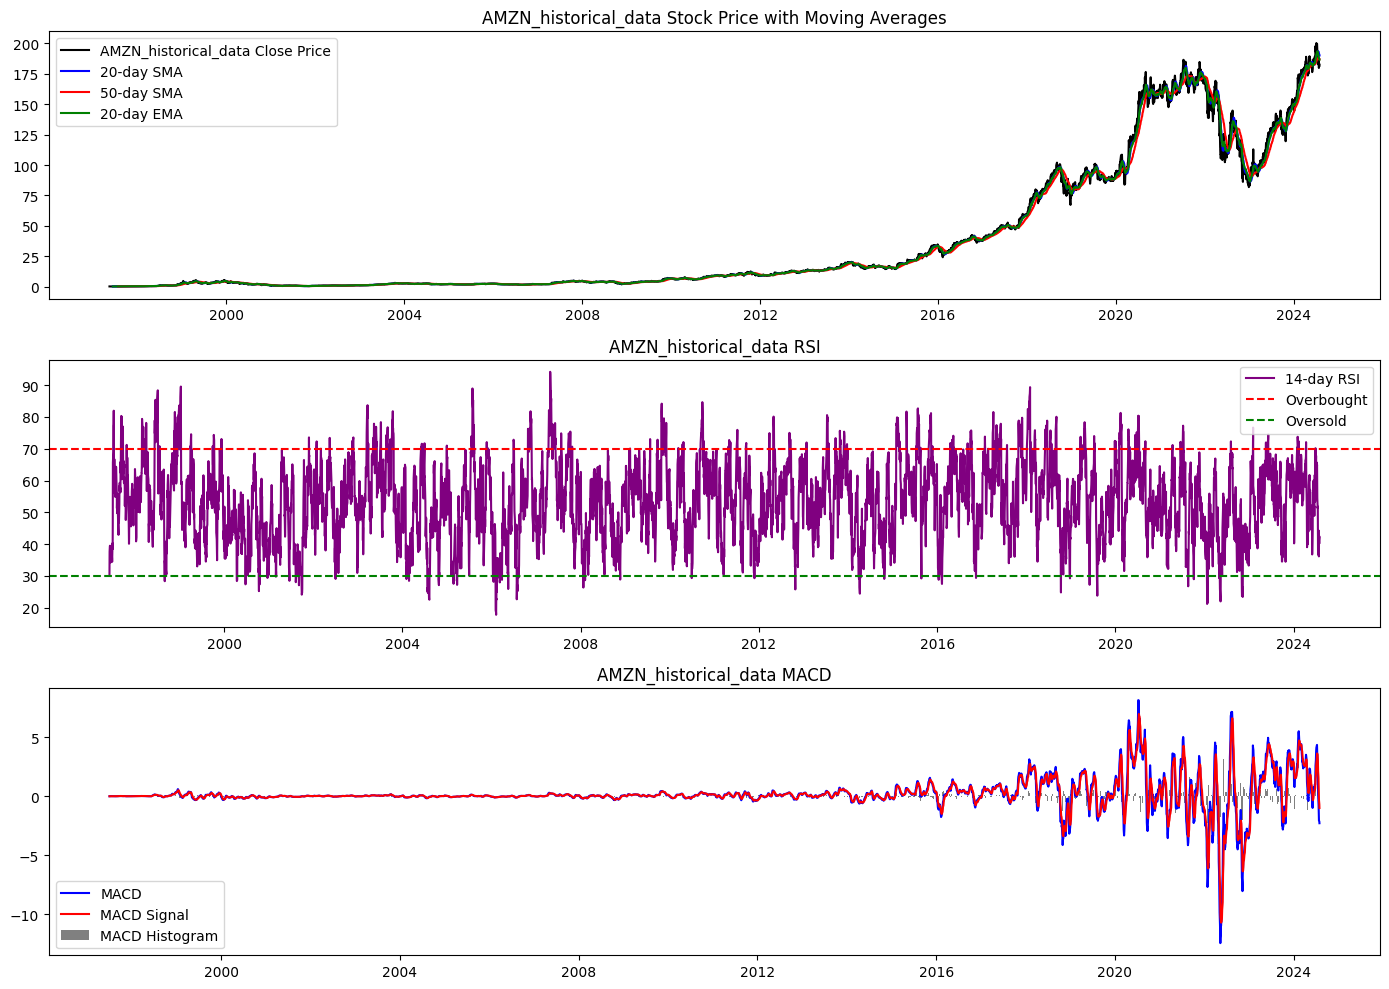

Saved processed data to ../data/yfinance_data\processed_AMZN_historical_data.csv.

Processing GOOG_historical_data.csv...
Data loaded successfully.
Missing values in each column:
 Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
Number of duplicate rows: 0
Data types:
 Date             object
Open            float64
High            float64
Low             float64
Close           float64
Adj Close       float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object


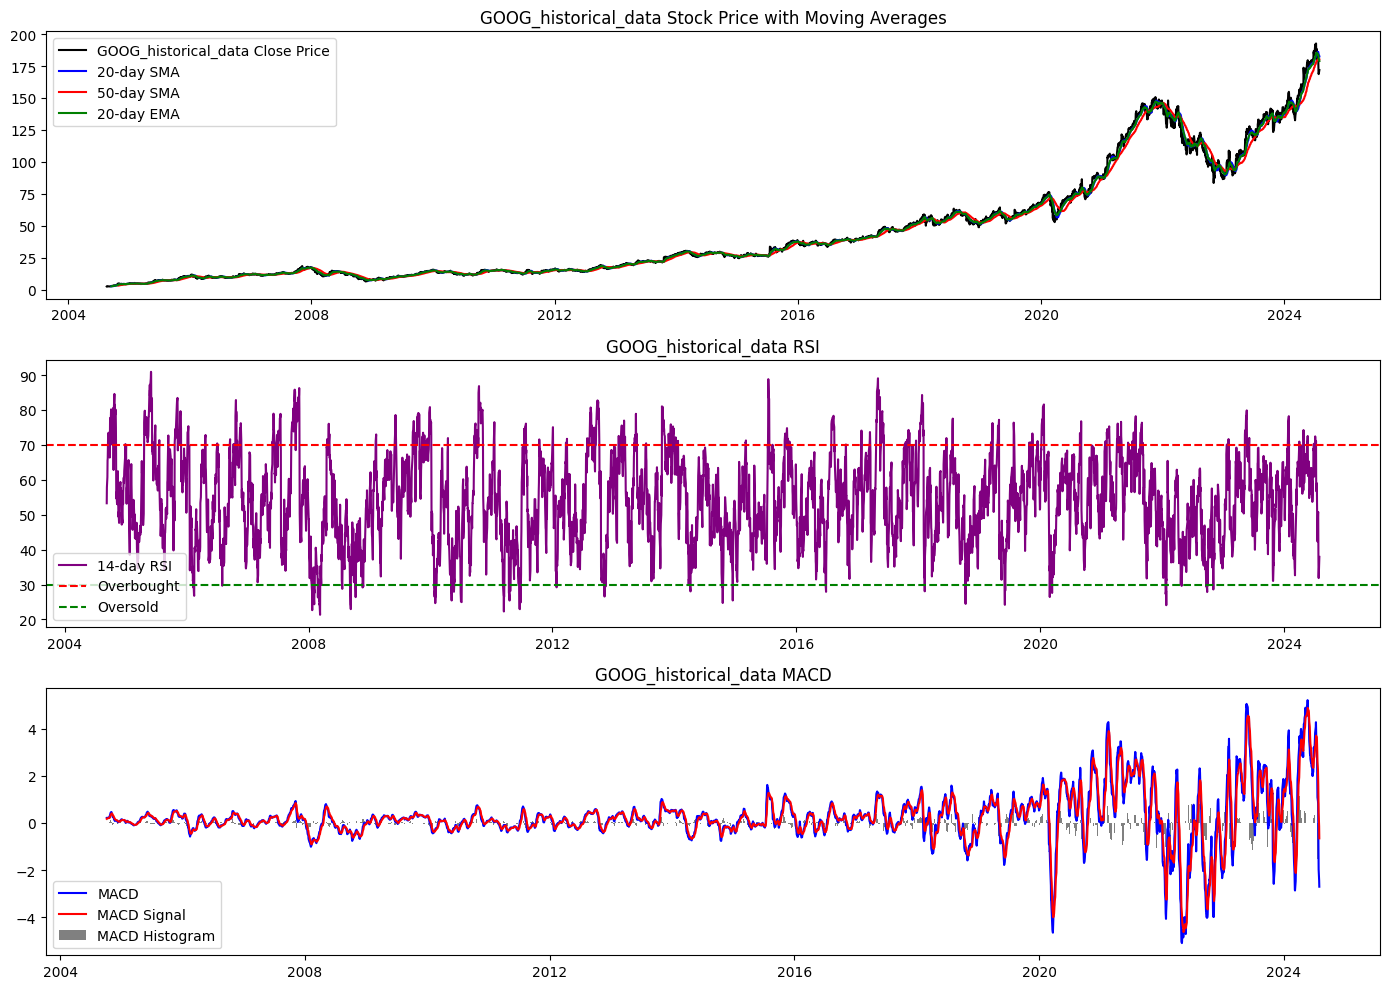

Saved processed data to ../data/yfinance_data\processed_GOOG_historical_data.csv.

Processing META_historical_data.csv...
Data loaded successfully.
Missing values in each column:
 Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
Number of duplicate rows: 0
Data types:
 Date             object
Open            float64
High            float64
Low             float64
Close           float64
Adj Close       float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object


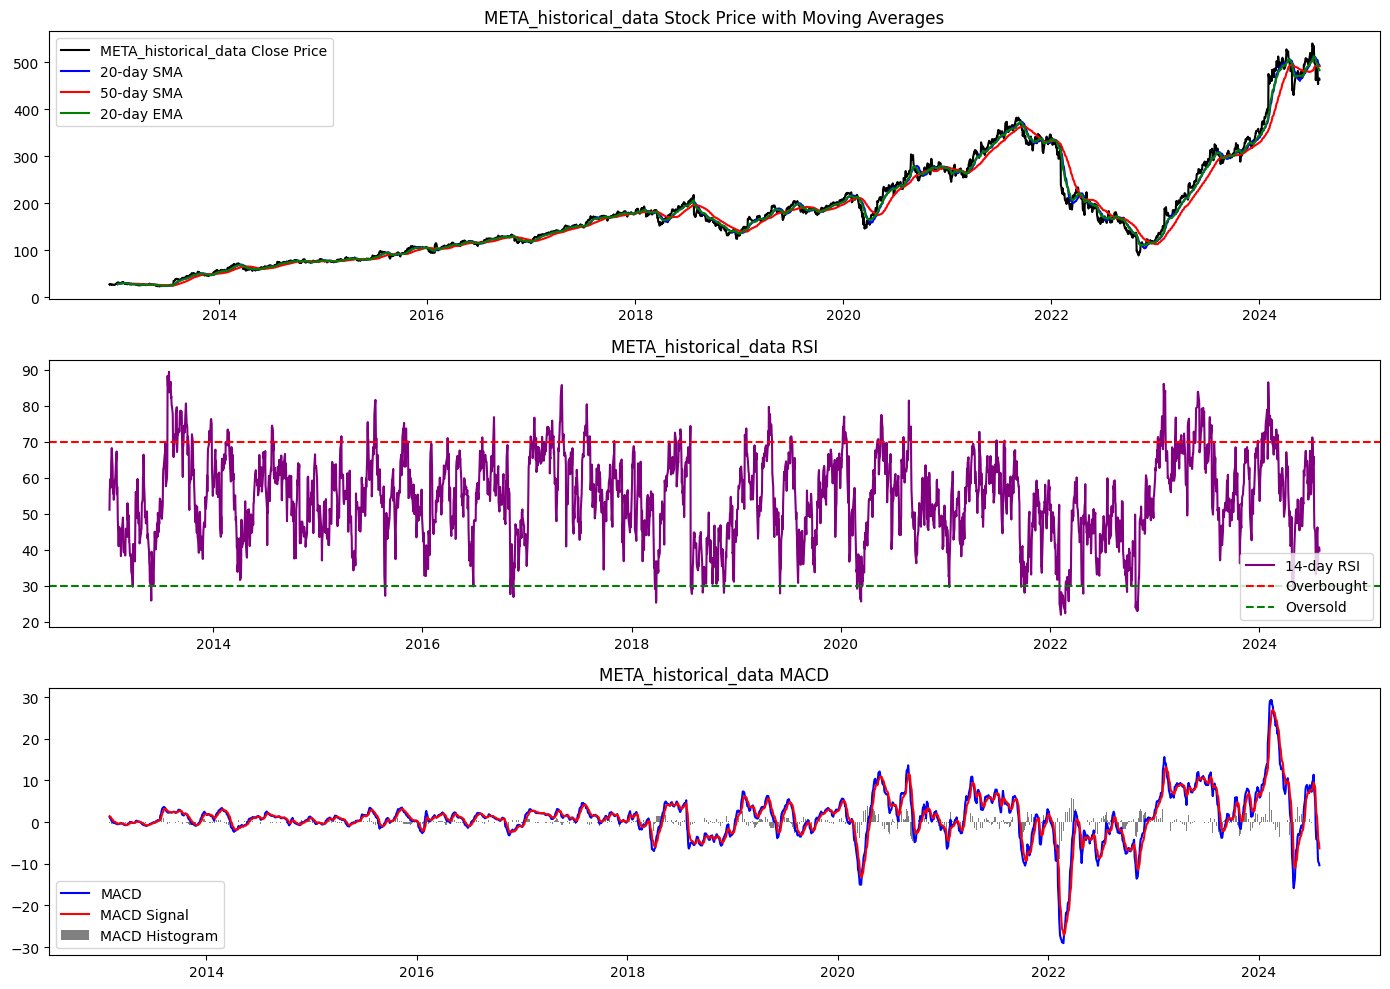

Saved processed data to ../data/yfinance_data\processed_META_historical_data.csv.

Processing MSFT_historical_data.csv...
Data loaded successfully.
Missing values in each column:
 Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
Number of duplicate rows: 0
Data types:
 Date             object
Open            float64
High            float64
Low             float64
Close           float64
Adj Close       float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object


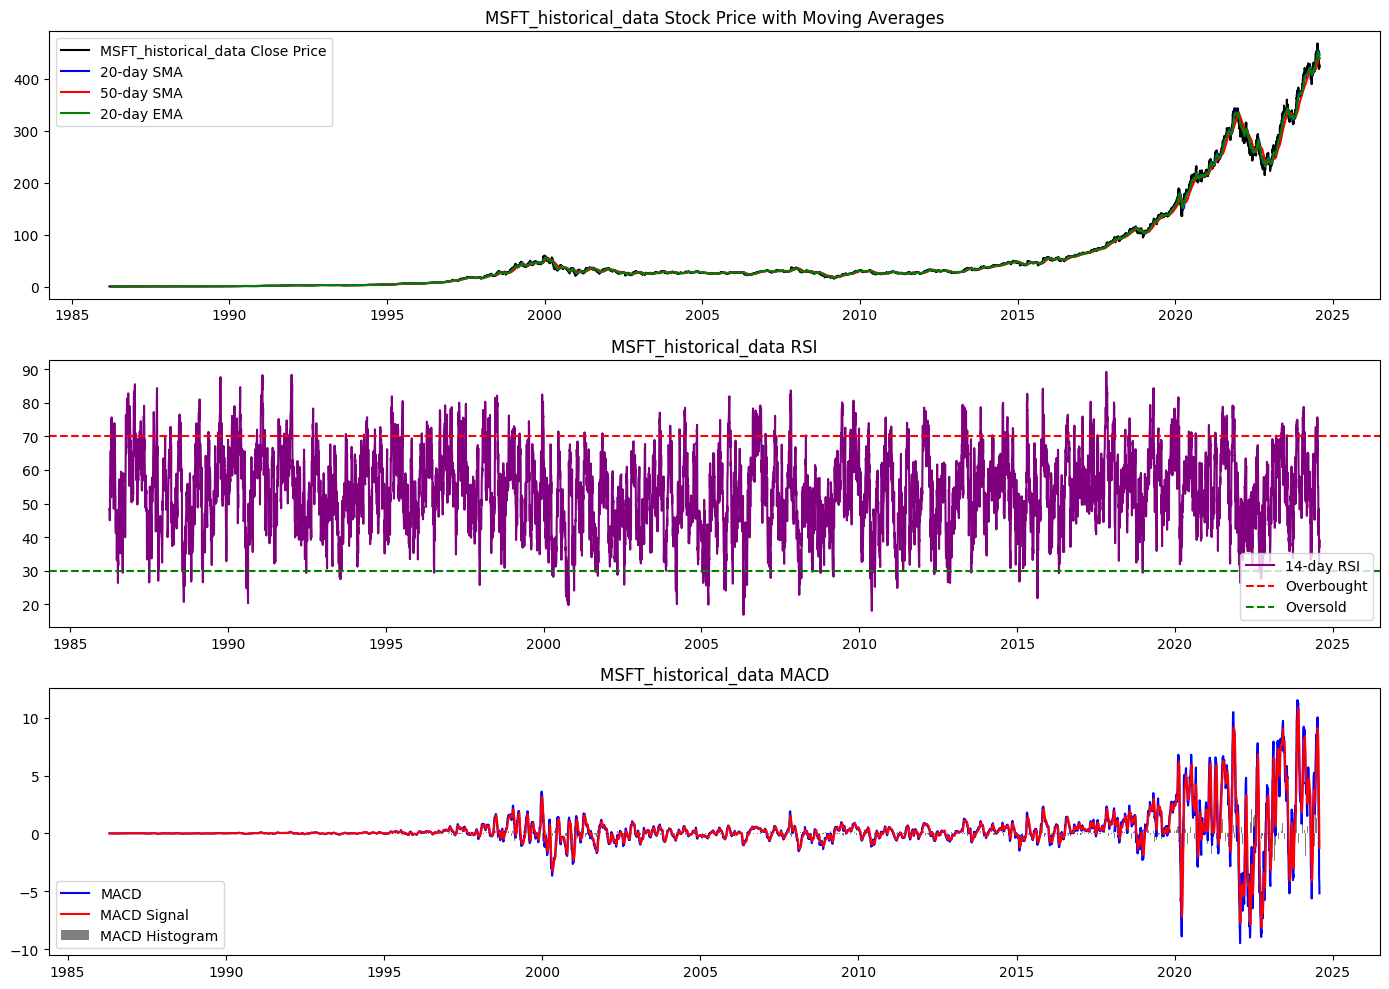

Saved processed data to ../data/yfinance_data\processed_MSFT_historical_data.csv.

Processing NVDA_historical_data.csv...
Data loaded successfully.
Missing values in each column:
 Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
Number of duplicate rows: 0
Data types:
 Date             object
Open            float64
High            float64
Low             float64
Close           float64
Adj Close       float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object


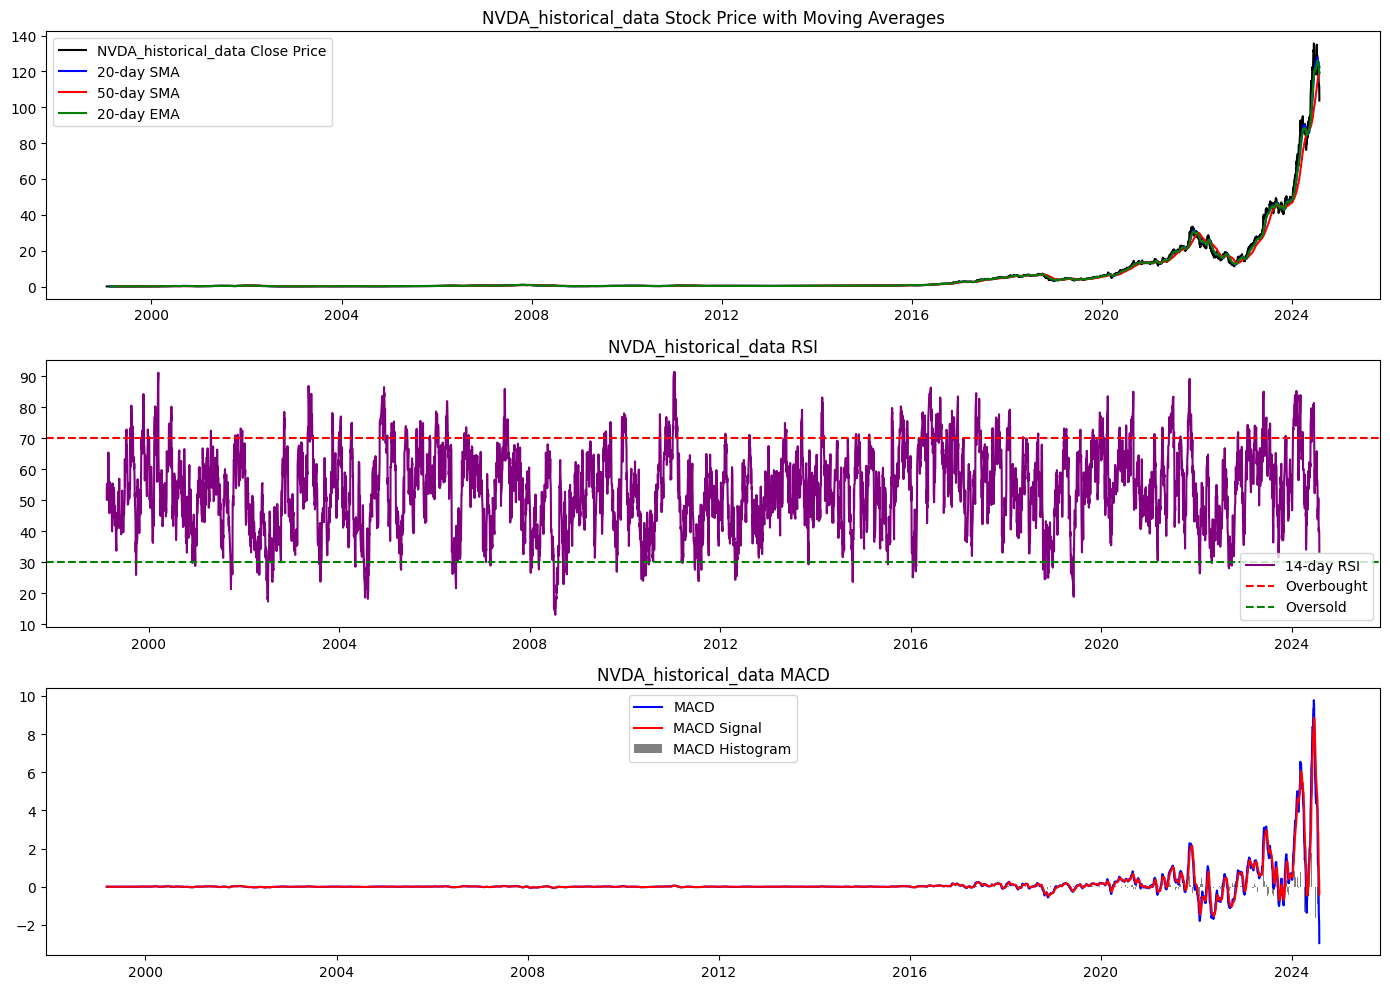

Saved processed data to ../data/yfinance_data\processed_NVDA_historical_data.csv.

Processing TSLA_historical_data.csv...
Data loaded successfully.
Missing values in each column:
 Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
Number of duplicate rows: 0
Data types:
 Date             object
Open            float64
High            float64
Low             float64
Close           float64
Adj Close       float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object


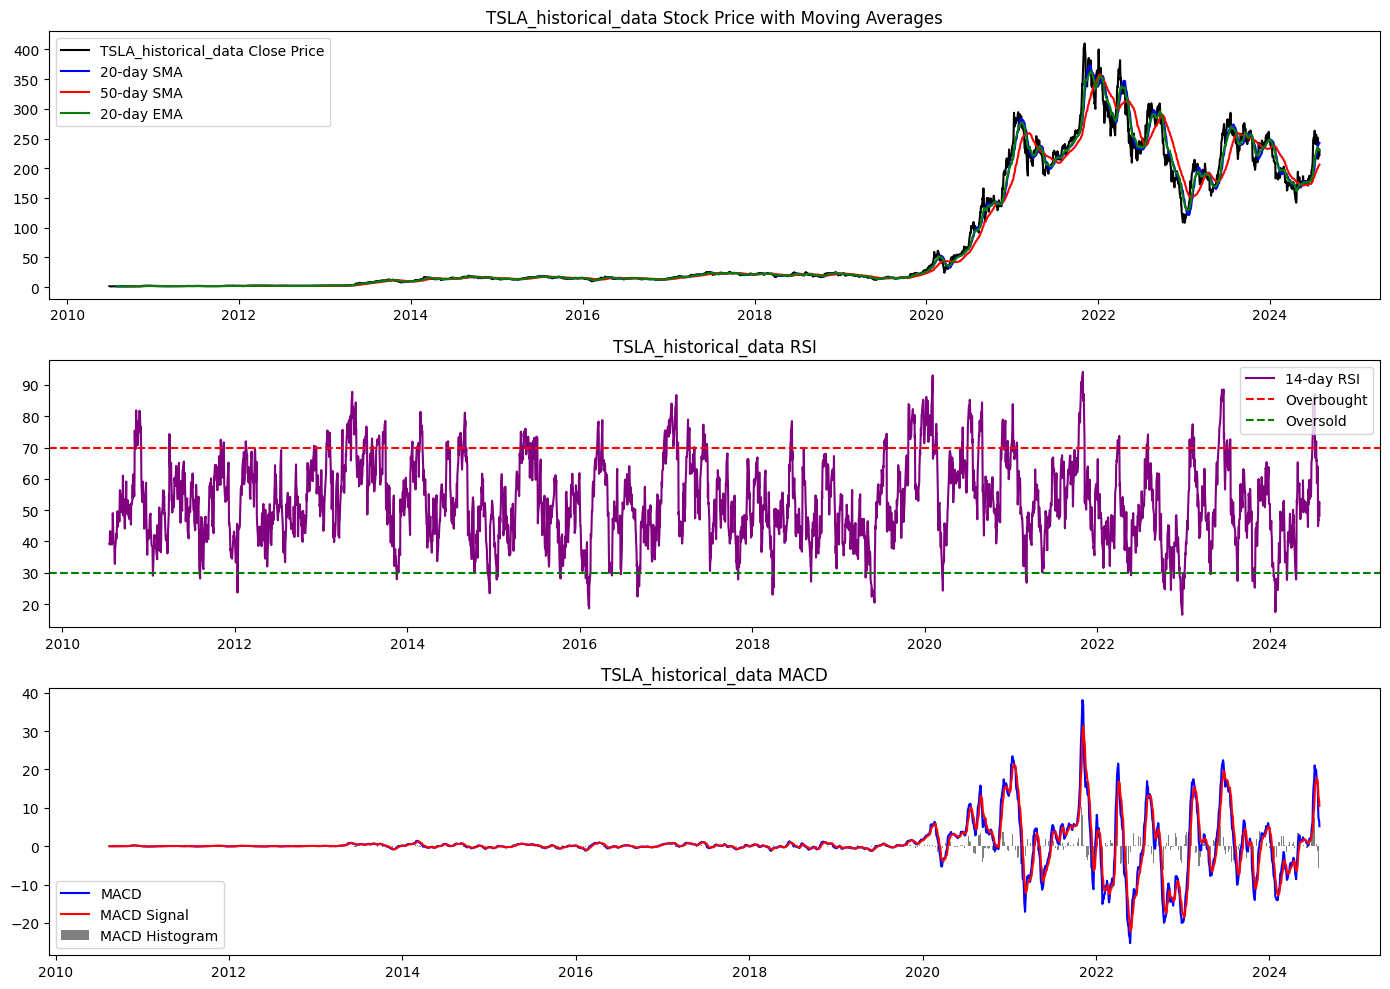

Saved processed data to ../data/yfinance_data\processed_TSLA_historical_data.csv.



In [15]:
data_utils.process_all_stocks('../data/yfinance_data')

## Task 3

## Correlation between news and stock movement

### Data Preparation

##### Normalize Dates

##### Perform Sentiment Analysis

##### Calculate Stock Movements

#### Correlation Analysis

In [8]:
# merged_data.head(10)


,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Unnamed: 0,headline,url,publisher,stock,polarity,sentiment
0,2009-04-27 00:00:00+00:00,4.389286,4.464286,4.380714,4.454643,3.761836,480690000,0.0,0.0,522587,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,Charles Lewis Sizemore CFA,FT,0.000000,neutral
1,2009-04-27 00:00:00+00:00,4.389286,4.464286,4.380714,4.454643,3.761836,480690000,0.0,0.0,1396488,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,Charles Lewis Sizemore CFA,Y,0.000000,neutral
2,2009-04-29 00:00:00+00:00,4.458929,4.530357,4.422500,4.469286,3.774201,458110800,0.0,0.0,1834,Going Against the Herd,https://www.benzinga.com/charles-lewis-sizemor...,Charles Lewis Sizemore CFA,A,0.000000,neutral
3,2009-05-22 00:00:00+00:00,4.430357,4.435000,4.348214,4.375000,3.694580,297998400,0.0,0.0,68387,Charles Sizemore Radio Interview Saturday Morning,https://www.benzinga.com/11218/charles-sizemor...,Charles Lewis Sizemore CFA,AM,0.000000,neutral
4,2009-05-27 00:00:00+00:00,4.706429,4.820714,4.675357,4.751786,4.012765,646422000,0.0,0.0,430147,MRM a $15-$20+ stock - FIT new information - J...,https://www.benzinga.com/superman/2009/5/27/mr...,superman,EPS,0.268182,positive
5,2009-05-27 00:00:00+00:00,4.706429,4.820714,4.675357,4.751786,4.012765,646422000,0.0,0.0,430148,"JVA perks to 39% gain, SMCG ready, MRM to cont...",https://www.benzinga.com/superman/2009/5/27/jv...,superman,EPS,0.200000,positive
6,2009-05-27 00:00:00+00:00,4.706429,4.820714,4.675357,4.751786,4.012765,646422000,0.0,0.0,561526,"JVA perks to 39% gain, SMCG ready, MRM to cont...",https://www.benzinga.com/superman/2009/5/27/jv...,superman,GMCR,0.200000,positive
7,2009-05-27 00:00:00+00:00,4.706429,4.820714,4.675357,4.751786,4.012765,646422000,0.0,0.0,714846,MRM a $15-$20+ stock - FIT new information - J...,https://www.benzinga.com/superman/2009/5/27/mr...,superman,JVA,0.268182,positive
8,2009-05-27 00:00:00+00:00,4.706429,4.820714,4.675357,4.751786,4.012765,646422000,0.0,0.0,714847,"JVA perks to 39% gain, SMCG ready, MRM to cont...",https://www.benzinga.com/superman/2009/5/27/jv...,superman,JVA,0.200000,positive
9,2009-05-27 00:00:00+00:00,4.706429,4.820714,4.675357,4.751786,4.012765,646422000,0.0,0.0,1081067,MRM a $15-$20+ stock - FIT new information - J...,https://www.benzinga.com/superman/2009/5/27/mr...,superman,RF,0.268182,positive


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from correlation_utils import process_stock_data

# Load the news data and ensure 'Date' column is properly formatted
news_data = pd.read_csv('../data/raw_analyst_ratings.csv', parse_dates=['date'])
news_data.rename(columns={'date': 'Date'}, inplace=True)
news_data['Date'] = pd.to_datetime(news_data['Date'], format='ISO8601')
news_data['Date'] = pd.to_datetime(news_data['Date']).dt.tz_convert('UTC')

# Process one stock at a time

# Example for AAPL
stock_filepath = '../data/yfinance_data/AAPL_historical_data.csv'
correlation_aapl, merged_data_aapl = process_stock_data(stock_filepath, news_data)
print(f"Correlation for AAPL: {correlation_aapl}")

# Analyze the result for AAPL
# (You can write down your observations, create plots, etc.)

# Example for MSFT
# stock_filepath = '../data/yfinance_data/MSFT_historical_data.csv'
# correlation_msft = process_stock_data(stock_filepath, news_data)
# print(f"Correlation for MSFT: {correlation_msft}")

# Analyze the result for MSFT
# (Repeat the process for each stock you're analyzing)


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from correlation_utils import process_stock_data

# Load the news data and ensure 'Date' column is properly formatted
news_data = pd.read_csv('../data/raw_analyst_ratings.csv', parse_dates=['date'])
news_data.rename(columns={'date': 'Date'}, inplace=True)
news_data['Date'] = pd.to_datetime(news_data['Date'], format='ISO8601')
news_data['Date'] = pd.to_datetime(news_data['Date']).dt.tz_convert('UTC')

# Process one stock at a time

# Example for AAPL
stock_filepath = '../data/yfinance_data/AAPL_historical_data.csv'
correlation_aapl, merged_data_aapl = process_stock_data(stock_filepath, news_data)
print(f"Correlation for AAPL: {correlation_aapl}")

# Analyze the result for AAPL
# (You can write down your observations, create plots, etc.)

# Example for MSFT
# stock_filepath = '../data/yfinance_data/MSFT_historical_data.csv'
# correlation_msft = process_stock_data(stock_filepath, news_data)
# print(f"Correlation for MSFT: {correlation_msft}")

# Analyze the result for MSFT
# (Repeat the process for each stock you're analyzing)


Correlation for AAPL: 0.00516138148444045


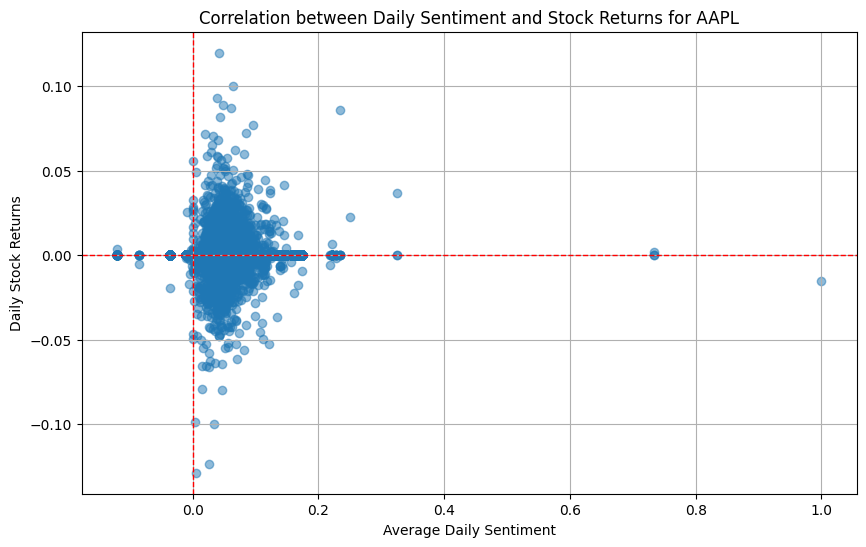

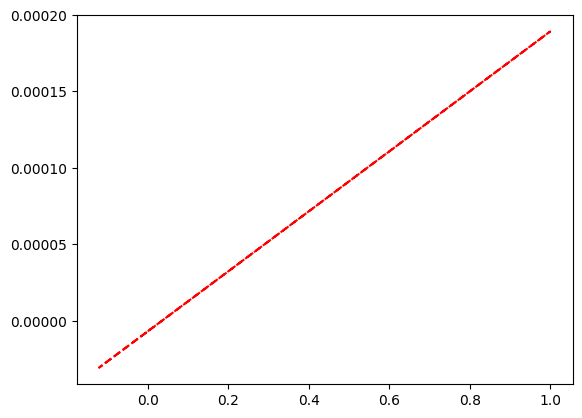

In [6]:
# Plotting the correlation
plt.figure(figsize=(10, 6))
plt.scatter(merged_data_aapl['Average_Sentiment'], merged_data_aapl['Daily_Returns'], alpha=0.5)
plt.title('Correlation between Daily Sentiment and Stock Returns for AAPL')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Stock Returns')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

# Drop rows with NaN values in both columns simultaneously
merged_data_clean = merged_data_aapl[['Average_Sentiment', 'Daily_Returns']].dropna()

# Calculate and plot the trend line
z = np.polyfit(merged_data_clean['Average_Sentiment'], merged_data_clean['Daily_Returns'], 1)
p = np.poly1d(z)
plt.plot(merged_data_clean['Average_Sentiment'], p(merged_data_clean['Average_Sentiment']), "r--")
plt.show()

In [3]:
stock_filepath = '../data/yfinance_data/AMZN_historical_data.csv'
correlation_amzn,merged_data_amzn = process_stock_data(stock_filepath, news_data)
print(f"Correlation for AMZN: {correlation_amzn}")

Correlation for AMZN: 0.0021495608750480674


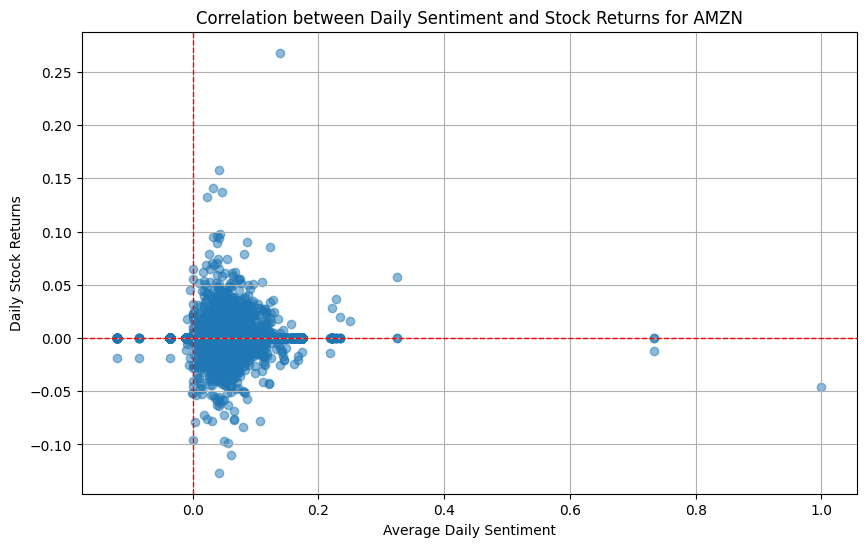

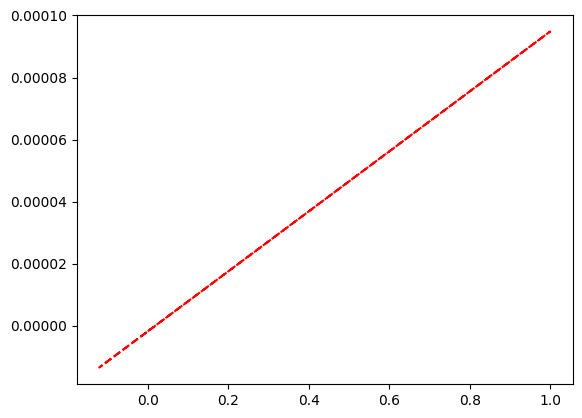

In [11]:
# Plotting the correlation
plt.figure(figsize=(10, 6))
plt.scatter(merged_data_amzn['Average_Sentiment'], merged_data_amzn['Daily_Returns'], alpha=0.5)
plt.title('Correlation between Daily Sentiment and Stock Returns for AMZN')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Stock Returns')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

# Drop rows with NaN values in both columns simultaneously
merged_data_clean = merged_data_amzn[['Average_Sentiment', 'Daily_Returns']].dropna()

# Calculate and plot the trend line
z = np.polyfit(merged_data_clean['Average_Sentiment'], merged_data_clean['Daily_Returns'], 1)
p = np.poly1d(z)
plt.plot(merged_data_clean['Average_Sentiment'], p(merged_data_clean['Average_Sentiment']), "r--")
plt.show()

In [4]:
stock_filepath = '../data/yfinance_data/GOOG_historical_data.csv'
correlation_goog,merged_data_goog = process_stock_data(stock_filepath, news_data)
print(f"Correlation for GOOG: {correlation_goog}")

Correlation for GOOG: 0.0026503602561351427


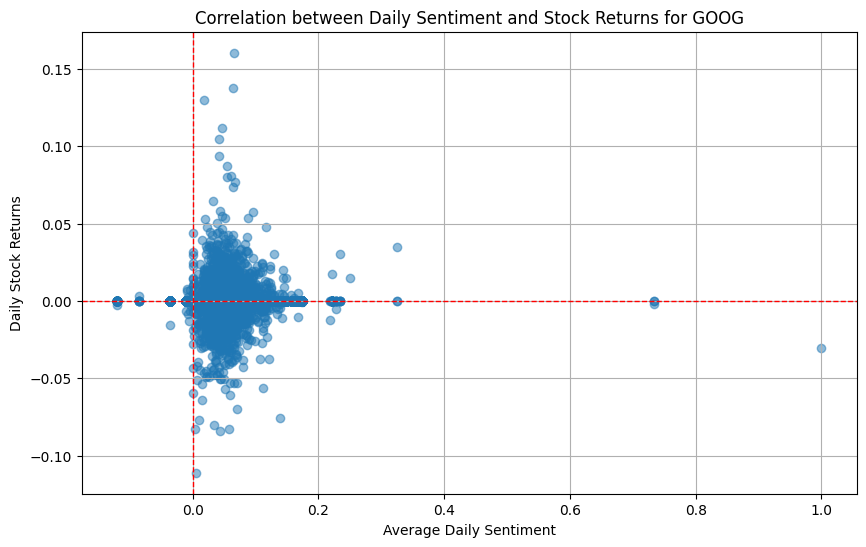

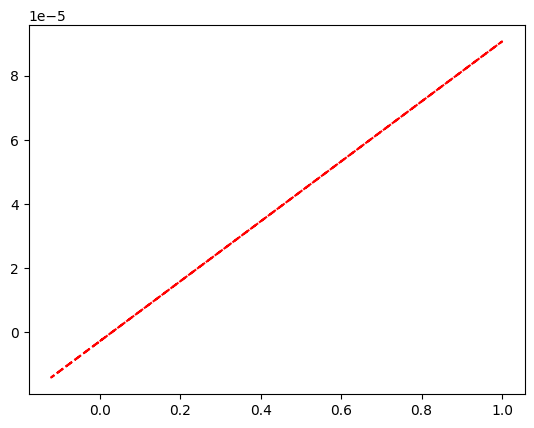

In [12]:
# Plotting the correlation
plt.figure(figsize=(10, 6))
plt.scatter(merged_data_goog['Average_Sentiment'], merged_data_goog['Daily_Returns'], alpha=0.5)
plt.title('Correlation between Daily Sentiment and Stock Returns for GOOG')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Stock Returns')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

# Drop rows with NaN values in both columns simultaneously
merged_data_clean = merged_data_goog[['Average_Sentiment', 'Daily_Returns']].dropna()

# Calculate and plot the trend line
z = np.polyfit(merged_data_clean['Average_Sentiment'], merged_data_clean['Daily_Returns'], 1)
p = np.poly1d(z)
plt.plot(merged_data_clean['Average_Sentiment'], p(merged_data_clean['Average_Sentiment']), "r--")
plt.show()

In [23]:
stock_filepath = '../data/yfinance_data/META_historical_data.csv'
correlation_meta,merged_data_meta = process_stock_data(stock_filepath, news_data)
print(f"Correlation for META: {correlation_meta}")

Correlation for META: 0.004082139751253382


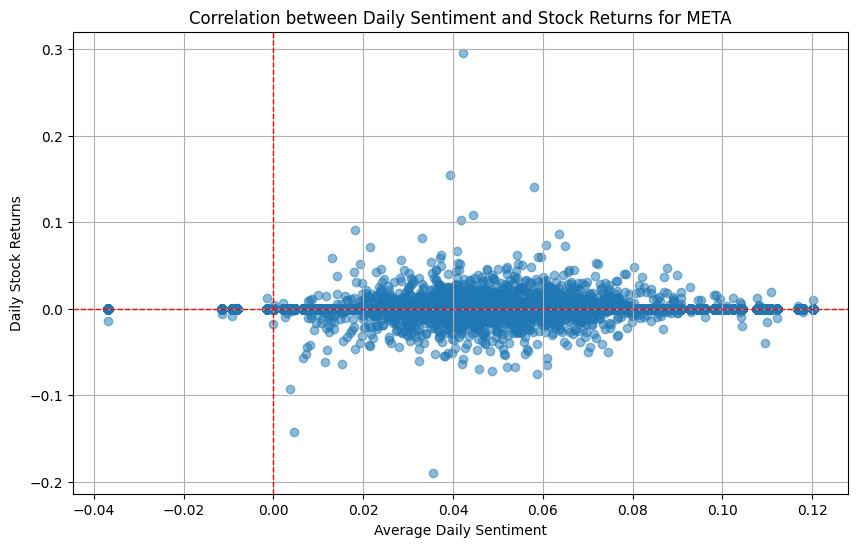

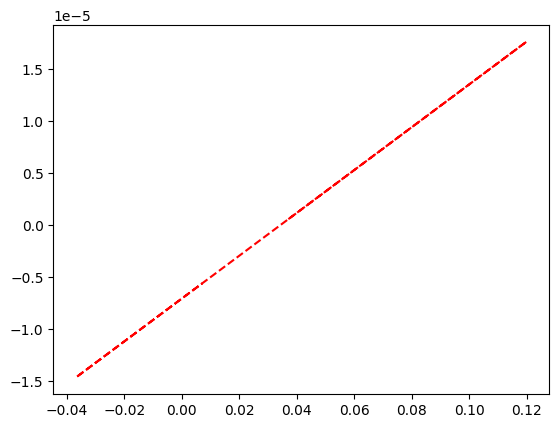

In [13]:
# Plotting the correlation
plt.figure(figsize=(10, 6))
plt.scatter(merged_data_meta['Average_Sentiment'], merged_data_meta['Daily_Returns'], alpha=0.5)
plt.title('Correlation between Daily Sentiment and Stock Returns for META')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Stock Returns')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

# Drop rows with NaN values in both columns simultaneously
merged_data_clean = merged_data_meta[['Average_Sentiment', 'Daily_Returns']].dropna()

# Calculate and plot the trend line
z = np.polyfit(merged_data_clean['Average_Sentiment'], merged_data_clean['Daily_Returns'], 1)
p = np.poly1d(z)
plt.plot(merged_data_clean['Average_Sentiment'], p(merged_data_clean['Average_Sentiment']), "r--")
plt.show()

In [22]:
stock_filepath = '../data/yfinance_data/MSFT_historical_data.csv'
correlation_msft,merged_data_msft = process_stock_data(stock_filepath, news_data)
print(f"Correlation for MSFT: {correlation_msft}")

Correlation for MSFT: 0.003319786307758298


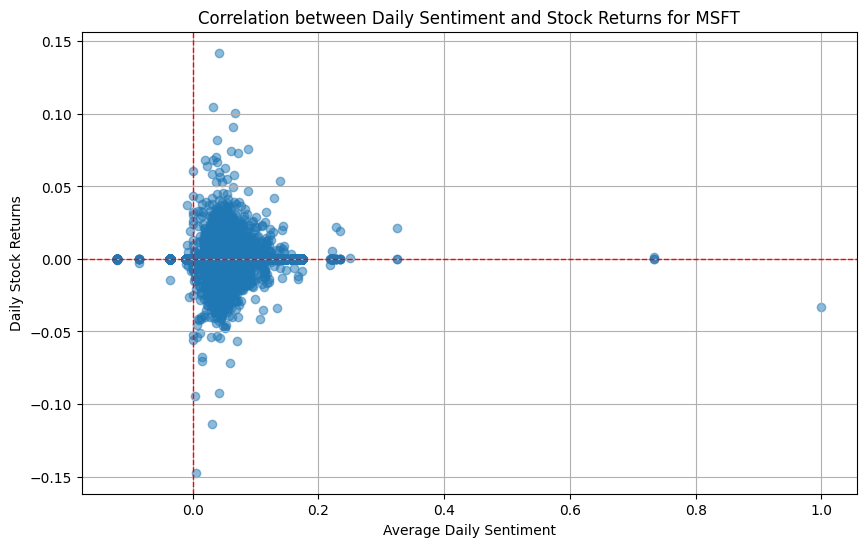

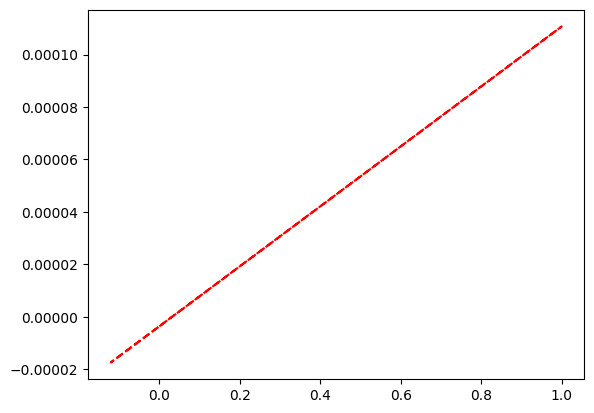

In [14]:
# Plotting the correlation
plt.figure(figsize=(10, 6))
plt.scatter(merged_data_msft['Average_Sentiment'], merged_data_msft['Daily_Returns'], alpha=0.5)
plt.title('Correlation between Daily Sentiment and Stock Returns for MSFT')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Stock Returns')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

# Drop rows with NaN values in both columns simultaneously
merged_data_clean = merged_data_msft[['Average_Sentiment', 'Daily_Returns']].dropna()

# Calculate and plot the trend line
z = np.polyfit(merged_data_clean['Average_Sentiment'], merged_data_clean['Daily_Returns'], 1)
p = np.poly1d(z)
plt.plot(merged_data_clean['Average_Sentiment'], p(merged_data_clean['Average_Sentiment']), "r--")
plt.show()

In [21]:
stock_filepath = '../data/yfinance_data/NVDA_historical_data.csv'
correlation_nvda,merged_data_nvda = process_stock_data(stock_filepath, news_data)
print(f"Correlation for NVDA: {correlation_nvda}")

Correlation for NVDA: -0.00013265945643344776


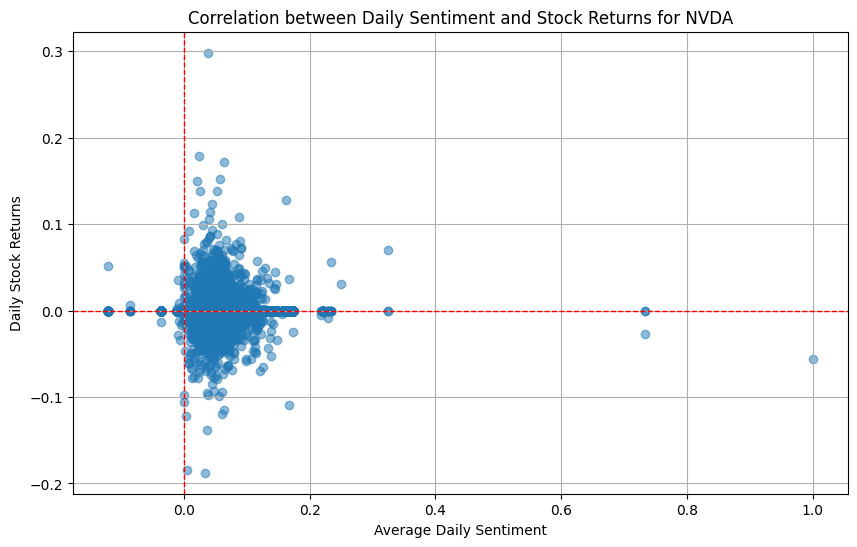

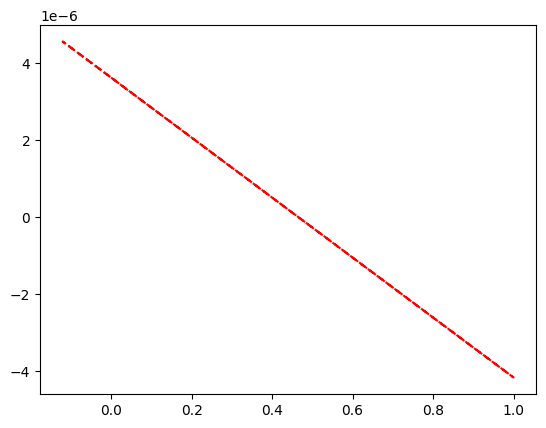

In [17]:
# Plotting the correlation
plt.figure(figsize=(10, 6))
plt.scatter(merged_data_nvda['Average_Sentiment'], merged_data_nvda['Daily_Returns'], alpha=0.5)
plt.title('Correlation between Daily Sentiment and Stock Returns for NVDA')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Stock Returns')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

# Drop rows with NaN values in both columns simultaneously
merged_data_clean = merged_data_nvda[['Average_Sentiment', 'Daily_Returns']].dropna()

# Calculate and plot the trend line
z = np.polyfit(merged_data_clean['Average_Sentiment'], merged_data_clean['Daily_Returns'], 1)
p = np.poly1d(z)
plt.plot(merged_data_clean['Average_Sentiment'], p(merged_data_clean['Average_Sentiment']), "r--")
plt.show()

In [19]:
stock_filepath = '../data/yfinance_data/TSLA_historical_data.csv'
correlation_tsla,merged_data_tsla = process_stock_data(stock_filepath, news_data)
print(f"Correlation for TSLA: {correlation_tsla}")

Correlation for TSLA: 0.002459047153262939


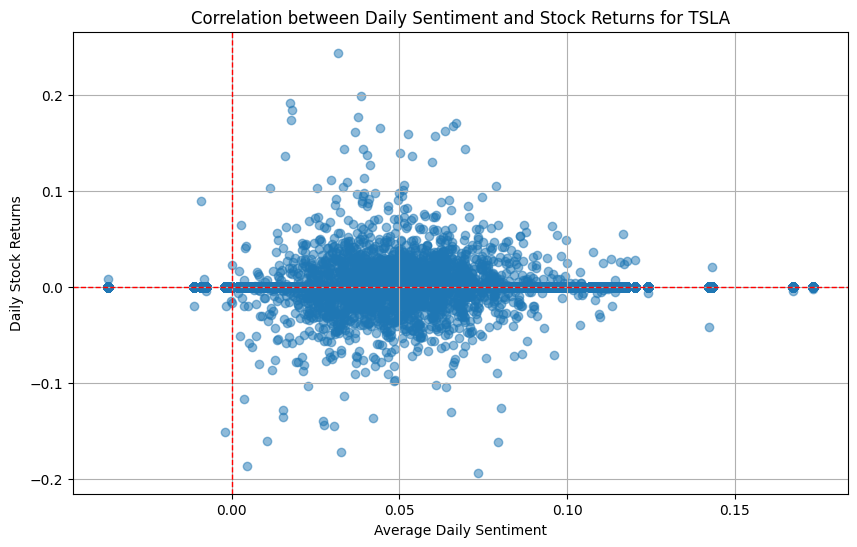

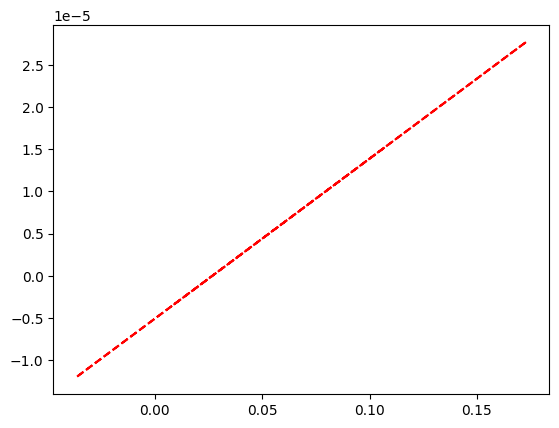

In [20]:
# Plotting the correlation
plt.figure(figsize=(10, 6))
plt.scatter(merged_data_tsla['Average_Sentiment'], merged_data_tsla['Daily_Returns'], alpha=0.5)
plt.title('Correlation between Daily Sentiment and Stock Returns for TSLA')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Stock Returns')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

# Drop rows with NaN values in both columns simultaneously
merged_data_clean = merged_data_tsla[['Average_Sentiment', 'Daily_Returns']].dropna()

# Calculate and plot the trend line
z = np.polyfit(merged_data_clean['Average_Sentiment'], merged_data_clean['Daily_Returns'], 1)
p = np.poly1d(z)
plt.plot(merged_data_clean['Average_Sentiment'], p(merged_data_clean['Average_Sentiment']), "r--")
plt.show()